In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.7 MB 10 kB/s 
     |████████████████████████████████| 17.3 MB 83 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.

In [3]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

Cloning into 'tcc'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 393 (delta 183), reused 310 (delta 103), pack-reused 0
Receiving objects: 100% (393/393), 49.42 MiB | 21.34 MiB/s, done.
Resolving deltas: 100% (183/183), done.
/content/tcc


In [4]:
!rm -rf mmsegmentation
!git clone -b v0.20.2 https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6379, done.
remote: Counting objects: 100% (882/882), done.
remote: Compressing objects: 100% (484/484), done.
remote: Total 6379 (delta 523), reused 593 (delta 390), pack-reused 5497
Receiving objects: 100% (6379/6379), 12.76 MiB | 25.83 MiB/s, done.
Resolving deltas: 100% (4592/4592), done.
Note: checking out '991b0512b9f4835275957e4c4896b5f4c4696eac'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

/content/tcc/mmsegmentation
Obtaining file:///content/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [6]:
!rm -rf ToTrain/
!unzip /content/drive/MyDrive/TCC/ToTrain.zip

Archive:  /content/drive/MyDrive/TCC/ToTrain.zip
   creating: ToTrain/
   creating: ToTrain/annotations/
  inflating: ToTrain/annotations/image020-roi1.tif  
  inflating: ToTrain/annotations/image008-roi1.tif  
  inflating: ToTrain/annotations/image032-roi1.tif  
  inflating: ToTrain/annotations/image019-roi2.tif  
  inflating: ToTrain/annotations/image019-roi5.tif  
  inflating: ToTrain/annotations/image058-roi5.tif  
  inflating: ToTrain/annotations/image038-roi4.tif  
  inflating: ToTrain/annotations/image058-roi1.tif  
  inflating: ToTrain/annotations/image021-roi3.tif  
  inflating: ToTrain/annotations/image006-roi2.tif  
  inflating: ToTrain/annotations/image021-roi6.tif  
  inflating: ToTrain/annotations/image038-roi1.tif  
  inflating: ToTrain/annotations/image003-2-roi3.tif  
  inflating: ToTrain/annotations/image038-roi3.tif  
  inflating: ToTrain/annotations/image039-roi3.tif  
  inflating: ToTrain/annotations/image017-roi1.tif  
  inflating: ToTrain/annotations/image004-roi

In [7]:
data_root = 'ToTrain'
img_dir = 'images'
ann_dir = 'annotations'

In [8]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

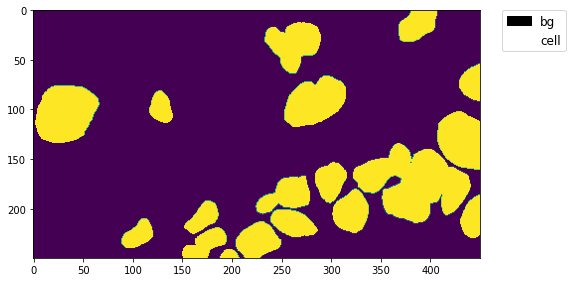

In [9]:
# Let's take a look at the segmentation map we got

img = Image.open('ToTrain/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [10]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [11]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.tif', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [12]:
cfg = Config.fromfile('../models/pspnet_resnest.py')

In [13]:
cfg.runner.max_epochs = 50
cfg.work_dir = './work_dirs/psp_resnest_50'
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'DysplasiaDataSet'
data_root = 'ToTrain'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (256, 256)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(256, 256), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(256, 256),
        flip=False,
        transforms=[
            dict(type='Resize

In [14]:
datasets = [build_dataset(cfg.data.train)]

2022-03-07 22:39:47,423 - mmseg - INFO - Loaded 96 images


In [15]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [16]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-03-07 22:39:54,956 - mmseg - INFO - Loaded 24 images
2022-03-07 22:39:54,965 - mmseg - INFO - Start running, host: root@f3014a7b6466, work_dir: /content/tcc/mmsegmentation/work_dirs/psp_unet_50
2022-03-07 22:39:54,972 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 6.8 task/s, elapsed: 4s, ETA:     0s

2022-03-07 22:40:35,342 - mmseg - INFO - per class results:
2022-03-07 22:40:35,345 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 50.69 | 37.28 |
|  cell | 53.05 | 80.66 |
+-------+-------+-------+
2022-03-07 22:40:35,347 - mmseg - INFO - Summary:
2022-03-07 22:40:35,350 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 51.9 | 51.87 | 58.97 |
+------+-------+-------+
2022-03-07 22:40:35,354 - mmseg - INFO - Epoch(val) [1][24]	aAcc: 0.5190, mDice: 0.5187, mAcc: 0.5897, Dice.bg: 0.5069, Dice.cell: 0.5305, Acc.bg: 0.3728, Acc.cell: 0.8066
2022-03-07 22:41:11,956 - mmseg - INFO - Epoch [2][12/12]	lr: 9.822e-03, eta: 0:27:49, time: 2.888, data_time: 0.191, memory: 5170, decode.loss_ce: 0.4748, decode.acc_seg: 51.5466, aux.loss_ce: 0.1861, aux.acc_seg: 53.8192, loss: 0.6609


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:41:15,268 - mmseg - INFO - per class results:
2022-03-07 22:41:15,272 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.99 | 97.09 |
|  cell | 34.16 | 21.78 |
+-------+-------+-------+
2022-03-07 22:41:15,276 - mmseg - INFO - Summary:
2022-03-07 22:41:15,278 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 71.71 | 58.07 | 59.43 |
+-------+-------+-------+
2022-03-07 22:41:15,283 - mmseg - INFO - Epoch(val) [2][24]	aAcc: 0.7171, mDice: 0.5807, mAcc: 0.5943, Dice.bg: 0.8199, Dice.cell: 0.3416, Acc.bg: 0.9709, Acc.cell: 0.2178
2022-03-07 22:41:51,857 - mmseg - INFO - Epoch [3][12/12]	lr: 9.643e-03, eta: 0:27:12, time: 2.886, data_time: 0.194, memory: 5170, decode.loss_ce: 0.4495, decode.acc_seg: 57.8928, aux.loss_ce: 0.1811, aux.acc_seg: 57.2044, loss: 0.6306


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:41:55,194 - mmseg - INFO - per class results:
2022-03-07 22:41:55,197 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.32 | 95.47 |
|  cell | 52.75 | 39.02 |
+-------+-------+-------+
2022-03-07 22:41:55,200 - mmseg - INFO - Summary:
2022-03-07 22:41:55,202 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.45 | 68.54 | 67.25 |
+-------+-------+-------+
2022-03-07 22:41:55,206 - mmseg - INFO - Epoch(val) [3][24]	aAcc: 0.7645, mDice: 0.6854, mAcc: 0.6725, Dice.bg: 0.8432, Dice.cell: 0.5275, Acc.bg: 0.9547, Acc.cell: 0.3902
2022-03-07 22:42:31,765 - mmseg - INFO - Epoch [4][12/12]	lr: 9.464e-03, eta: 0:26:36, time: 2.885, data_time: 0.190, memory: 5170, decode.loss_ce: 0.3977, decode.acc_seg: 57.0069, aux.loss_ce: 0.1709, aux.acc_seg: 54.6999, loss: 0.5687


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:42:35,124 - mmseg - INFO - per class results:
2022-03-07 22:42:35,127 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.63 | 95.04 |
|  cell | 59.94 | 46.97 |
+-------+-------+-------+
2022-03-07 22:42:35,130 - mmseg - INFO - Summary:
2022-03-07 22:42:35,135 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.85 | 72.78 | 71.01 |
+-------+-------+-------+
2022-03-07 22:42:35,139 - mmseg - INFO - Epoch(val) [4][24]	aAcc: 0.7885, mDice: 0.7278, mAcc: 0.7101, Dice.bg: 0.8563, Dice.cell: 0.5994, Acc.bg: 0.9504, Acc.cell: 0.4697
2022-03-07 22:43:11,643 - mmseg - INFO - Epoch [5][12/12]	lr: 9.284e-03, eta: 0:26:00, time: 2.880, data_time: 0.189, memory: 5170, decode.loss_ce: 0.4081, decode.acc_seg: 64.2767, aux.loss_ce: 0.1739, aux.acc_seg: 61.7156, loss: 0.5820


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:43:14,985 - mmseg - INFO - per class results:
2022-03-07 22:43:14,989 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.83 | 92.62 |
|  cell | 64.34 | 54.32 |
+-------+-------+-------+
2022-03-07 22:43:14,991 - mmseg - INFO - Summary:
2022-03-07 22:43:14,994 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.72 | 75.09 | 73.47 |
+-------+-------+-------+
2022-03-07 22:43:14,998 - mmseg - INFO - Epoch(val) [5][24]	aAcc: 0.7972, mDice: 0.7509, mAcc: 0.7347, Dice.bg: 0.8583, Dice.cell: 0.6434, Acc.bg: 0.9262, Acc.cell: 0.5432
2022-03-07 22:43:51,466 - mmseg - INFO - Epoch [6][12/12]	lr: 9.104e-03, eta: 0:25:24, time: 2.877, data_time: 0.191, memory: 5170, decode.loss_ce: 0.3833, decode.acc_seg: 61.0925, aux.loss_ce: 0.1640, aux.acc_seg: 59.2466, loss: 0.5473


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:43:54,793 - mmseg - INFO - per class results:
2022-03-07 22:43:54,797 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.31 | 90.27 |
|  cell | 69.02 | 62.78 |
+-------+-------+-------+
2022-03-07 22:43:54,799 - mmseg - INFO - Summary:
2022-03-07 22:43:54,801 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.01 | 77.67 | 76.53 |
+-------+-------+-------+
2022-03-07 22:43:54,805 - mmseg - INFO - Epoch(val) [6][24]	aAcc: 0.8101, mDice: 0.7767, mAcc: 0.7653, Dice.bg: 0.8631, Dice.cell: 0.6902, Acc.bg: 0.9027, Acc.cell: 0.6278
2022-03-07 22:44:31,205 - mmseg - INFO - Epoch [7][12/12]	lr: 8.924e-03, eta: 0:24:48, time: 2.871, data_time: 0.186, memory: 5170, decode.loss_ce: 0.3463, decode.acc_seg: 61.2824, aux.loss_ce: 0.1497, aux.acc_seg: 59.5411, loss: 0.4960


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:44:34,510 - mmseg - INFO - per class results:
2022-03-07 22:44:34,512 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.61 | 88.13 |
|  cell | 72.24 | 69.75 |
+-------+-------+-------+
2022-03-07 22:44:34,515 - mmseg - INFO - Summary:
2022-03-07 22:44:34,520 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.94 | 79.43 | 78.94 |
+-------+-------+-------+
2022-03-07 22:44:34,522 - mmseg - INFO - Epoch(val) [7][24]	aAcc: 0.8194, mDice: 0.7943, mAcc: 0.7894, Dice.bg: 0.8661, Dice.cell: 0.7224, Acc.bg: 0.8813, Acc.cell: 0.6975
2022-03-07 22:45:11,136 - mmseg - INFO - Epoch [8][12/12]	lr: 8.743e-03, eta: 0:24:14, time: 2.889, data_time: 0.197, memory: 5170, decode.loss_ce: 0.3394, decode.acc_seg: 58.6430, aux.loss_ce: 0.1443, aux.acc_seg: 57.4539, loss: 0.4838


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:45:14,481 - mmseg - INFO - per class results:
2022-03-07 22:45:14,483 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.9 | 86.53 |
|  cell | 71.64 | 70.61 |
+-------+-------+-------+
2022-03-07 22:45:14,485 - mmseg - INFO - Summary:
2022-03-07 22:45:14,488 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.17 | 78.77 | 78.57 |
+-------+-------+-------+
2022-03-07 22:45:14,492 - mmseg - INFO - Epoch(val) [8][24]	aAcc: 0.8117, mDice: 0.7877, mAcc: 0.7857, Dice.bg: 0.8590, Dice.cell: 0.7164, Acc.bg: 0.8653, Acc.cell: 0.7061
2022-03-07 22:45:51,007 - mmseg - INFO - Epoch [9][12/12]	lr: 8.562e-03, eta: 0:23:39, time: 2.882, data_time: 0.186, memory: 5170, decode.loss_ce: 0.3575, decode.acc_seg: 64.7604, aux.loss_ce: 0.1531, aux.acc_seg: 62.9188, loss: 0.5106


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:45:54,361 - mmseg - INFO - per class results:
2022-03-07 22:45:54,364 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.22 | 90.85 |
|  cell | 71.45 | 65.58 |
+-------+-------+-------+
2022-03-07 22:45:54,367 - mmseg - INFO - Summary:
2022-03-07 22:45:54,372 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.34 | 79.33 | 78.22 |
+-------+-------+-------+
2022-03-07 22:45:54,376 - mmseg - INFO - Epoch(val) [9][24]	aAcc: 0.8234, mDice: 0.7933, mAcc: 0.7822, Dice.bg: 0.8722, Dice.cell: 0.7145, Acc.bg: 0.9085, Acc.cell: 0.6558
2022-03-07 22:46:30,945 - mmseg - INFO - Epoch [10][12/12]	lr: 8.381e-03, eta: 0:23:04, time: 2.886, data_time: 0.189, memory: 5170, decode.loss_ce: 0.3413, decode.acc_seg: 60.7532, aux.loss_ce: 0.1428, aux.acc_seg: 59.7897, loss: 0.4840
2022-03-07 22:46:30,951 - mmseg - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:46:35,485 - mmseg - INFO - per class results:
2022-03-07 22:46:35,489 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.36 | 84.13 |
|  cell | 75.11 | 78.92 |
+-------+-------+-------+
2022-03-07 22:46:35,490 - mmseg - INFO - Summary:
2022-03-07 22:46:35,496 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.38 | 80.73 | 81.53 |
+-------+-------+-------+
2022-03-07 22:46:35,498 - mmseg - INFO - Epoch(val) [10][24]	aAcc: 0.8238, mDice: 0.8073, mAcc: 0.8153, Dice.bg: 0.8636, Dice.cell: 0.7511, Acc.bg: 0.8413, Acc.cell: 0.7892
2022-03-07 22:47:12,044 - mmseg - INFO - Epoch [11][12/12]	lr: 8.199e-03, eta: 0:22:30, time: 2.884, data_time: 0.191, memory: 5170, decode.loss_ce: 0.3411, decode.acc_seg: 63.1884, aux.loss_ce: 0.1432, aux.acc_seg: 61.9457, loss: 0.4843


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:47:15,368 - mmseg - INFO - per class results:
2022-03-07 22:47:15,370 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.77 | 85.56 |
|  cell | 75.02 | 77.08 |
+-------+-------+-------+
2022-03-07 22:47:15,374 - mmseg - INFO - Summary:
2022-03-07 22:47:15,377 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.71 |  80.9 | 81.32 |
+-------+-------+-------+
2022-03-07 22:47:15,379 - mmseg - INFO - Epoch(val) [11][24]	aAcc: 0.8271, mDice: 0.8090, mAcc: 0.8132, Dice.bg: 0.8677, Dice.cell: 0.7502, Acc.bg: 0.8556, Acc.cell: 0.7708
2022-03-07 22:47:51,990 - mmseg - INFO - Epoch [12][12/12]	lr: 8.016e-03, eta: 0:21:55, time: 2.889, data_time: 0.197, memory: 5170, decode.loss_ce: 0.3669, decode.acc_seg: 65.6723, aux.loss_ce: 0.1518, aux.acc_seg: 64.5695, loss: 0.5187


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:47:55,291 - mmseg - INFO - per class results:
2022-03-07 22:47:55,296 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.57 | 83.23 |
|  cell | 73.78 | 77.75 |
+-------+-------+-------+
2022-03-07 22:47:55,298 - mmseg - INFO - Summary:
2022-03-07 22:47:55,308 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.38 | 79.67 | 80.49 |
+-------+-------+-------+
2022-03-07 22:47:55,310 - mmseg - INFO - Epoch(val) [12][24]	aAcc: 0.8138, mDice: 0.7967, mAcc: 0.8049, Dice.bg: 0.8557, Dice.cell: 0.7378, Acc.bg: 0.8323, Acc.cell: 0.7775
2022-03-07 22:48:31,867 - mmseg - INFO - Epoch [13][12/12]	lr: 7.833e-03, eta: 0:21:21, time: 2.884, data_time: 0.192, memory: 5170, decode.loss_ce: 0.3295, decode.acc_seg: 64.0846, aux.loss_ce: 0.1403, aux.acc_seg: 62.4225, loss: 0.4697


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:48:35,187 - mmseg - INFO - per class results:
2022-03-07 22:48:35,190 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.71 | 84.62 |
|  cell | 75.63 | 79.21 |
+-------+-------+-------+
2022-03-07 22:48:35,191 - mmseg - INFO - Summary:
2022-03-07 22:48:35,196 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 82.8 | 81.17 | 81.92 |
+------+-------+-------+
2022-03-07 22:48:35,199 - mmseg - INFO - Epoch(val) [13][24]	aAcc: 0.8280, mDice: 0.8117, mAcc: 0.8192, Dice.bg: 0.8671, Dice.cell: 0.7563, Acc.bg: 0.8462, Acc.cell: 0.7921
2022-03-07 22:49:11,695 - mmseg - INFO - Epoch [14][12/12]	lr: 7.650e-03, eta: 0:20:46, time: 2.879, data_time: 0.188, memory: 5170, decode.loss_ce: 0.3248, decode.acc_seg: 63.3653, aux.loss_ce: 0.1377, aux.acc_seg: 62.1280, loss: 0.4625


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.4 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:49:14,972 - mmseg - INFO - per class results:
2022-03-07 22:49:14,976 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.2 | 86.53 |
|  cell | 75.37 |  76.5 |
+-------+-------+-------+
2022-03-07 22:49:14,979 - mmseg - INFO - Summary:
2022-03-07 22:49:14,983 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.15 | 81.28 | 81.52 |
+-------+-------+-------+
2022-03-07 22:49:14,988 - mmseg - INFO - Epoch(val) [14][24]	aAcc: 0.8315, mDice: 0.8128, mAcc: 0.8152, Dice.bg: 0.8720, Dice.cell: 0.7537, Acc.bg: 0.8653, Acc.cell: 0.7650
2022-03-07 22:49:51,540 - mmseg - INFO - Epoch [15][12/12]	lr: 7.466e-03, eta: 0:20:11, time: 2.884, data_time: 0.193, memory: 5170, decode.loss_ce: 0.3191, decode.acc_seg: 60.5586, aux.loss_ce: 0.1339, aux.acc_seg: 59.5980, loss: 0.4530


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:49:54,829 - mmseg - INFO - per class results:
2022-03-07 22:49:54,833 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.13 | 86.74 |
|  cell | 74.99 | 75.64 |
+-------+-------+-------+
2022-03-07 22:49:54,835 - mmseg - INFO - Summary:
2022-03-07 22:49:54,846 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 83.0 | 81.06 | 81.19 |
+------+-------+-------+
2022-03-07 22:49:54,849 - mmseg - INFO - Epoch(val) [15][24]	aAcc: 0.8300, mDice: 0.8106, mAcc: 0.8119, Dice.bg: 0.8713, Dice.cell: 0.7499, Acc.bg: 0.8674, Acc.cell: 0.7564
2022-03-07 22:50:31,321 - mmseg - INFO - Epoch [16][12/12]	lr: 7.282e-03, eta: 0:19:36, time: 2.878, data_time: 0.188, memory: 5170, decode.loss_ce: 0.3257, decode.acc_seg: 67.3108, aux.loss_ce: 0.1355, aux.acc_seg: 66.4662, loss: 0.4611


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.4 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:50:34,599 - mmseg - INFO - per class results:
2022-03-07 22:50:34,601 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.48 | 86.36 |
|  cell | 76.27 | 78.19 |
+-------+-------+-------+
2022-03-07 22:50:34,606 - mmseg - INFO - Summary:
2022-03-07 22:50:34,608 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.61 | 81.87 | 82.28 |
+-------+-------+-------+
2022-03-07 22:50:34,614 - mmseg - INFO - Epoch(val) [16][24]	aAcc: 0.8361, mDice: 0.8187, mAcc: 0.8228, Dice.bg: 0.8748, Dice.cell: 0.7627, Acc.bg: 0.8636, Acc.cell: 0.7819
2022-03-07 22:51:11,077 - mmseg - INFO - Epoch [17][12/12]	lr: 7.097e-03, eta: 0:19:02, time: 2.877, data_time: 0.190, memory: 5170, decode.loss_ce: 0.3119, decode.acc_seg: 62.5439, aux.loss_ce: 0.1289, aux.acc_seg: 61.6615, loss: 0.4408


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.4 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:51:14,350 - mmseg - INFO - per class results:
2022-03-07 22:51:14,353 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.46 |  84.6 |
|  cell | 74.99 | 78.17 |
+-------+-------+-------+
2022-03-07 22:51:14,355 - mmseg - INFO - Summary:
2022-03-07 22:51:14,364 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.43 | 80.73 | 81.39 |
+-------+-------+-------+
2022-03-07 22:51:14,366 - mmseg - INFO - Epoch(val) [17][24]	aAcc: 0.8243, mDice: 0.8073, mAcc: 0.8139, Dice.bg: 0.8646, Dice.cell: 0.7499, Acc.bg: 0.8460, Acc.cell: 0.7817
2022-03-07 22:51:50,815 - mmseg - INFO - Epoch [18][12/12]	lr: 6.911e-03, eta: 0:18:27, time: 2.876, data_time: 0.187, memory: 5170, decode.loss_ce: 0.3229, decode.acc_seg: 64.8481, aux.loss_ce: 0.1350, aux.acc_seg: 63.6431, loss: 0.4579


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:51:54,121 - mmseg - INFO - per class results:
2022-03-07 22:51:54,126 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.65 | 87.97 |
|  cell | 75.44 | 74.91 |
+-------+-------+-------+
2022-03-07 22:51:54,128 - mmseg - INFO - Summary:
2022-03-07 22:51:54,132 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.57 | 81.55 | 81.44 |
+-------+-------+-------+
2022-03-07 22:51:54,136 - mmseg - INFO - Epoch(val) [18][24]	aAcc: 0.8357, mDice: 0.8155, mAcc: 0.8144, Dice.bg: 0.8765, Dice.cell: 0.7544, Acc.bg: 0.8797, Acc.cell: 0.7491
2022-03-07 22:52:30,649 - mmseg - INFO - Epoch [19][12/12]	lr: 6.725e-03, eta: 0:17:52, time: 2.881, data_time: 0.189, memory: 5170, decode.loss_ce: 0.3191, decode.acc_seg: 62.9667, aux.loss_ce: 0.1314, aux.acc_seg: 62.0432, loss: 0.4506


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:52:33,974 - mmseg - INFO - per class results:
2022-03-07 22:52:33,977 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  86.1 | 82.34 |
|  cell | 75.91 | 82.42 |
+-------+-------+-------+
2022-03-07 22:52:33,980 - mmseg - INFO - Summary:
2022-03-07 22:52:33,984 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.37 |  81.0 | 82.38 |
+-------+-------+-------+
2022-03-07 22:52:33,990 - mmseg - INFO - Epoch(val) [19][24]	aAcc: 0.8237, mDice: 0.8100, mAcc: 0.8238, Dice.bg: 0.8610, Dice.cell: 0.7591, Acc.bg: 0.8234, Acc.cell: 0.8242
2022-03-07 22:53:10,498 - mmseg - INFO - Epoch [20][12/12]	lr: 6.539e-03, eta: 0:17:17, time: 2.880, data_time: 0.188, memory: 5170, decode.loss_ce: 0.3301, decode.acc_seg: 67.3676, aux.loss_ce: 0.1353, aux.acc_seg: 66.6467, loss: 0.4654
2022-03-07 22:53:10,502 - mmseg - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:53:14,876 - mmseg - INFO - per class results:
2022-03-07 22:53:14,881 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.68 | 84.07 |
|  cell |  76.0 | 80.51 |
+-------+-------+-------+
2022-03-07 22:53:14,882 - mmseg - INFO - Summary:
2022-03-07 22:53:14,885 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.87 | 81.34 | 82.29 |
+-------+-------+-------+
2022-03-07 22:53:14,891 - mmseg - INFO - Epoch(val) [20][24]	aAcc: 0.8287, mDice: 0.8134, mAcc: 0.8229, Dice.bg: 0.8668, Dice.cell: 0.7600, Acc.bg: 0.8407, Acc.cell: 0.8051
2022-03-07 22:53:51,438 - mmseg - INFO - Epoch [21][12/12]	lr: 6.351e-03, eta: 0:16:43, time: 2.884, data_time: 0.193, memory: 5170, decode.loss_ce: 0.3112, decode.acc_seg: 60.9786, aux.loss_ce: 0.1316, aux.acc_seg: 59.6739, loss: 0.4428


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:53:54,743 - mmseg - INFO - per class results:
2022-03-07 22:53:54,748 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.09 |  85.1 |
|  cell | 76.24 | 79.67 |
+-------+-------+-------+
2022-03-07 22:53:54,750 - mmseg - INFO - Summary:
2022-03-07 22:53:54,754 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.27 | 81.67 | 82.39 |
+-------+-------+-------+
2022-03-07 22:53:54,757 - mmseg - INFO - Epoch(val) [21][24]	aAcc: 0.8327, mDice: 0.8167, mAcc: 0.8239, Dice.bg: 0.8709, Dice.cell: 0.7624, Acc.bg: 0.8510, Acc.cell: 0.7967
2022-03-07 22:54:31,295 - mmseg - INFO - Epoch [22][12/12]	lr: 6.163e-03, eta: 0:16:08, time: 2.883, data_time: 0.192, memory: 5170, decode.loss_ce: 0.3295, decode.acc_seg: 64.5903, aux.loss_ce: 0.1315, aux.acc_seg: 64.3715, loss: 0.4609


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:54:34,610 - mmseg - INFO - per class results:
2022-03-07 22:54:34,613 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.38 | 85.82 |
|  cell | 76.44 | 79.12 |
+-------+-------+-------+
2022-03-07 22:54:34,614 - mmseg - INFO - Summary:
2022-03-07 22:54:34,617 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.57 | 81.91 | 82.47 |
+-------+-------+-------+
2022-03-07 22:54:34,620 - mmseg - INFO - Epoch(val) [22][24]	aAcc: 0.8357, mDice: 0.8191, mAcc: 0.8247, Dice.bg: 0.8738, Dice.cell: 0.7644, Acc.bg: 0.8582, Acc.cell: 0.7912
2022-03-07 22:55:11,125 - mmseg - INFO - Epoch [23][12/12]	lr: 5.975e-03, eta: 0:15:34, time: 2.880, data_time: 0.191, memory: 5170, decode.loss_ce: 0.3074, decode.acc_seg: 61.0238, aux.loss_ce: 0.1266, aux.acc_seg: 60.1567, loss: 0.4340


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:55:14,426 - mmseg - INFO - per class results:
2022-03-07 22:55:14,433 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.14 | 85.84 |
|  cell | 75.78 | 78.01 |
+-------+-------+-------+
2022-03-07 22:55:14,434 - mmseg - INFO - Summary:
2022-03-07 22:55:14,440 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 83.2 | 81.46 | 81.92 |
+------+-------+-------+
2022-03-07 22:55:14,442 - mmseg - INFO - Epoch(val) [23][24]	aAcc: 0.8320, mDice: 0.8146, mAcc: 0.8192, Dice.bg: 0.8714, Dice.cell: 0.7578, Acc.bg: 0.8584, Acc.cell: 0.7801
2022-03-07 22:55:50,930 - mmseg - INFO - Epoch [24][12/12]	lr: 5.786e-03, eta: 0:14:59, time: 2.879, data_time: 0.190, memory: 5170, decode.loss_ce: 0.3263, decode.acc_seg: 63.3048, aux.loss_ce: 0.1332, aux.acc_seg: 62.6466, loss: 0.4595


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.4 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:55:54,192 - mmseg - INFO - per class results:
2022-03-07 22:55:54,195 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.13 |  84.8 |
|  cell | 76.58 | 80.62 |
+-------+-------+-------+
2022-03-07 22:55:54,198 - mmseg - INFO - Summary:
2022-03-07 22:55:54,207 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.39 | 81.86 | 82.71 |
+-------+-------+-------+
2022-03-07 22:55:54,208 - mmseg - INFO - Epoch(val) [24][24]	aAcc: 0.8339, mDice: 0.8186, mAcc: 0.8271, Dice.bg: 0.8713, Dice.cell: 0.7658, Acc.bg: 0.8480, Acc.cell: 0.8062
2022-03-07 22:56:30,718 - mmseg - INFO - Epoch [25][12/12]	lr: 5.596e-03, eta: 0:14:24, time: 2.881, data_time: 0.191, memory: 5170, decode.loss_ce: 0.2945, decode.acc_seg: 63.5187, aux.loss_ce: 0.1207, aux.acc_seg: 62.7823, loss: 0.4152


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:56:34,009 - mmseg - INFO - per class results:
2022-03-07 22:56:34,012 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.52 | 85.81 |
|  cell | 76.82 | 79.78 |
+-------+-------+-------+
2022-03-07 22:56:34,014 - mmseg - INFO - Summary:
2022-03-07 22:56:34,018 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 83.78 | 82.17 | 82.8 |
+-------+-------+------+
2022-03-07 22:56:34,023 - mmseg - INFO - Epoch(val) [25][24]	aAcc: 0.8378, mDice: 0.8217, mAcc: 0.8280, Dice.bg: 0.8752, Dice.cell: 0.7682, Acc.bg: 0.8581, Acc.cell: 0.7978
2022-03-07 22:57:10,477 - mmseg - INFO - Epoch [26][12/12]	lr: 5.405e-03, eta: 0:13:50, time: 2.876, data_time: 0.188, memory: 5170, decode.loss_ce: 0.3041, decode.acc_seg: 65.9028, aux.loss_ce: 0.1268, aux.acc_seg: 65.0197, loss: 0.4309


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:57:13,792 - mmseg - INFO - per class results:
2022-03-07 22:57:13,795 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.46 | 85.67 |
|  cell | 76.76 | 79.85 |
+-------+-------+-------+
2022-03-07 22:57:13,797 - mmseg - INFO - Summary:
2022-03-07 22:57:13,803 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.71 | 82.11 | 82.76 |
+-------+-------+-------+
2022-03-07 22:57:13,805 - mmseg - INFO - Epoch(val) [26][24]	aAcc: 0.8371, mDice: 0.8211, mAcc: 0.8276, Dice.bg: 0.8746, Dice.cell: 0.7676, Acc.bg: 0.8567, Acc.cell: 0.7985
2022-03-07 22:57:50,237 - mmseg - INFO - Epoch [27][12/12]	lr: 5.214e-03, eta: 0:13:15, time: 2.874, data_time: 0.187, memory: 5170, decode.loss_ce: 0.3022, decode.acc_seg: 63.5844, aux.loss_ce: 0.1234, aux.acc_seg: 62.9318, loss: 0.4256


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:57:53,538 - mmseg - INFO - per class results:
2022-03-07 22:57:53,540 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.4 | 85.13 |
|  cell | 77.03 | 80.98 |
+-------+-------+-------+
2022-03-07 22:57:53,543 - mmseg - INFO - Summary:
2022-03-07 22:57:53,551 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.73 | 82.22 | 83.05 |
+-------+-------+-------+
2022-03-07 22:57:53,554 - mmseg - INFO - Epoch(val) [27][24]	aAcc: 0.8373, mDice: 0.8222, mAcc: 0.8305, Dice.bg: 0.8740, Dice.cell: 0.7703, Acc.bg: 0.8513, Acc.cell: 0.8098
2022-03-07 22:58:29,965 - mmseg - INFO - Epoch [28][12/12]	lr: 5.022e-03, eta: 0:12:40, time: 2.872, data_time: 0.180, memory: 5170, decode.loss_ce: 0.3027, decode.acc_seg: 63.9189, aux.loss_ce: 0.1243, aux.acc_seg: 63.2890, loss: 0.4270


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:58:33,252 - mmseg - INFO - per class results:
2022-03-07 22:58:33,254 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.85 | 87.16 |
|  cell | 76.64 | 77.82 |
+-------+-------+-------+
2022-03-07 22:58:33,256 - mmseg - INFO - Summary:
2022-03-07 22:58:33,260 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.01 | 82.24 | 82.49 |
+-------+-------+-------+
2022-03-07 22:58:33,262 - mmseg - INFO - Epoch(val) [28][24]	aAcc: 0.8401, mDice: 0.8224, mAcc: 0.8249, Dice.bg: 0.8785, Dice.cell: 0.7664, Acc.bg: 0.8716, Acc.cell: 0.7782
2022-03-07 22:59:09,793 - mmseg - INFO - Epoch [29][12/12]	lr: 4.829e-03, eta: 0:12:06, time: 2.882, data_time: 0.192, memory: 5170, decode.loss_ce: 0.3195, decode.acc_seg: 67.7607, aux.loss_ce: 0.1314, aux.acc_seg: 67.2959, loss: 0.4510


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 22:59:13,091 - mmseg - INFO - per class results:
2022-03-07 22:59:13,093 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.1 | 83.96 |
|  cell | 77.15 | 82.62 |
+-------+-------+-------+
2022-03-07 22:59:13,095 - mmseg - INFO - Summary:
2022-03-07 22:59:13,097 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.51 | 82.13 | 83.29 |
+-------+-------+-------+
2022-03-07 22:59:13,101 - mmseg - INFO - Epoch(val) [29][24]	aAcc: 0.8351, mDice: 0.8213, mAcc: 0.8329, Dice.bg: 0.8710, Dice.cell: 0.7715, Acc.bg: 0.8396, Acc.cell: 0.8262
2022-03-07 22:59:49,572 - mmseg - INFO - Epoch [30][12/12]	lr: 4.635e-03, eta: 0:11:31, time: 2.878, data_time: 0.190, memory: 5170, decode.loss_ce: 0.2913, decode.acc_seg: 63.5243, aux.loss_ce: 0.1193, aux.acc_seg: 62.9370, loss: 0.4105
2022-03-07 22:59:49,576 - mmseg - INFO - Saving checkpoint at 30 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 6.5 task/s, elapsed: 4s, ETA:     0s

2022-03-07 22:59:54,446 - mmseg - INFO - per class results:
2022-03-07 22:59:54,450 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.03 | 83.84 |
|  cell | 77.06 | 82.62 |
+-------+-------+-------+
2022-03-07 22:59:54,453 - mmseg - INFO - Summary:
2022-03-07 22:59:54,465 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.43 | 82.04 | 83.23 |
+-------+-------+-------+
2022-03-07 22:59:54,469 - mmseg - INFO - Epoch(val) [30][24]	aAcc: 0.8343, mDice: 0.8204, mAcc: 0.8323, Dice.bg: 0.8703, Dice.cell: 0.7706, Acc.bg: 0.8384, Acc.cell: 0.8262
2022-03-07 23:00:31,055 - mmseg - INFO - Epoch [31][12/12]	lr: 4.440e-03, eta: 0:10:57, time: 2.887, data_time: 0.196, memory: 5170, decode.loss_ce: 0.3025, decode.acc_seg: 65.9340, aux.loss_ce: 0.1241, aux.acc_seg: 65.4771, loss: 0.4266


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:00:34,353 - mmseg - INFO - per class results:
2022-03-07 23:00:34,356 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.94 | 86.91 |
|  cell | 77.08 | 78.87 |
+-------+-------+-------+
2022-03-07 23:00:34,357 - mmseg - INFO - Summary:
2022-03-07 23:00:34,361 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 84.2 | 82.51 | 82.89 |
+------+-------+-------+
2022-03-07 23:00:34,371 - mmseg - INFO - Epoch(val) [31][24]	aAcc: 0.8420, mDice: 0.8251, mAcc: 0.8289, Dice.bg: 0.8794, Dice.cell: 0.7708, Acc.bg: 0.8691, Acc.cell: 0.7887
2022-03-07 23:01:10,782 - mmseg - INFO - Epoch [32][12/12]	lr: 4.244e-03, eta: 0:10:22, time: 2.872, data_time: 0.188, memory: 5170, decode.loss_ce: 0.3306, decode.acc_seg: 68.3292, aux.loss_ce: 0.1356, aux.acc_seg: 67.8383, loss: 0.4662


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:01:14,064 - mmseg - INFO - per class results:
2022-03-07 23:01:14,068 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.53 | 85.48 |
|  cell | 77.08 | 80.61 |
+-------+-------+-------+
2022-03-07 23:01:14,072 - mmseg - INFO - Summary:
2022-03-07 23:01:14,074 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.84 |  82.3 | 83.05 |
+-------+-------+-------+
2022-03-07 23:01:14,076 - mmseg - INFO - Epoch(val) [32][24]	aAcc: 0.8384, mDice: 0.8230, mAcc: 0.8305, Dice.bg: 0.8753, Dice.cell: 0.7708, Acc.bg: 0.8548, Acc.cell: 0.8061
2022-03-07 23:01:50,531 - mmseg - INFO - Epoch [33][12/12]	lr: 4.047e-03, eta: 0:09:47, time: 2.876, data_time: 0.188, memory: 5170, decode.loss_ce: 0.2834, decode.acc_seg: 61.3652, aux.loss_ce: 0.1145, aux.acc_seg: 61.0938, loss: 0.3979


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:01:53,822 - mmseg - INFO - per class results:
2022-03-07 23:01:53,825 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.12 | 84.31 |
|  cell | 76.93 | 81.81 |
+-------+-------+-------+
2022-03-07 23:01:53,829 - mmseg - INFO - Summary:
2022-03-07 23:01:53,837 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.47 | 82.02 | 83.06 |
+-------+-------+-------+
2022-03-07 23:01:53,839 - mmseg - INFO - Epoch(val) [33][24]	aAcc: 0.8347, mDice: 0.8202, mAcc: 0.8306, Dice.bg: 0.8712, Dice.cell: 0.7693, Acc.bg: 0.8431, Acc.cell: 0.8181
2022-03-07 23:02:30,236 - mmseg - INFO - Epoch [34][12/12]	lr: 3.849e-03, eta: 0:09:13, time: 2.871, data_time: 0.186, memory: 5170, decode.loss_ce: 0.3149, decode.acc_seg: 67.9128, aux.loss_ce: 0.1288, aux.acc_seg: 67.4064, loss: 0.4437


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:02:33,516 - mmseg - INFO - per class results:
2022-03-07 23:02:33,520 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.15 | 84.42 |
|  cell | 76.93 | 81.69 |
+-------+-------+-------+
2022-03-07 23:02:33,525 - mmseg - INFO - Summary:
2022-03-07 23:02:33,527 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 83.5 | 82.04 | 83.05 |
+------+-------+-------+
2022-03-07 23:02:33,529 - mmseg - INFO - Epoch(val) [34][24]	aAcc: 0.8350, mDice: 0.8204, mAcc: 0.8305, Dice.bg: 0.8715, Dice.cell: 0.7693, Acc.bg: 0.8442, Acc.cell: 0.8169
2022-03-07 23:03:10,073 - mmseg - INFO - Epoch [35][12/12]	lr: 3.650e-03, eta: 0:08:38, time: 2.883, data_time: 0.192, memory: 5170, decode.loss_ce: 0.3271, decode.acc_seg: 67.6153, aux.loss_ce: 0.1336, aux.acc_seg: 67.0991, loss: 0.4607


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:03:13,418 - mmseg - INFO - per class results:
2022-03-07 23:03:13,424 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.26 | 85.16 |
|  cell | 76.62 | 80.25 |
+-------+-------+-------+
2022-03-07 23:03:13,431 - mmseg - INFO - Summary:
2022-03-07 23:03:13,434 - mmseg - INFO - 
+------+-------+------+
| aAcc | mDice | mAcc |
+------+-------+------+
| 83.5 | 81.94 | 82.7 |
+------+-------+------+
2022-03-07 23:03:13,438 - mmseg - INFO - Epoch(val) [35][24]	aAcc: 0.8350, mDice: 0.8194, mAcc: 0.8270, Dice.bg: 0.8726, Dice.cell: 0.7662, Acc.bg: 0.8516, Acc.cell: 0.8025
2022-03-07 23:03:50,025 - mmseg - INFO - Epoch [36][12/12]	lr: 3.450e-03, eta: 0:08:04, time: 2.887, data_time: 0.197, memory: 5170, decode.loss_ce: 0.3024, decode.acc_seg: 64.0459, aux.loss_ce: 0.1227, aux.acc_seg: 63.5156, loss: 0.4251


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:03:53,378 - mmseg - INFO - per class results:
2022-03-07 23:03:53,382 - mmseg - INFO - 
+-------+-------+------+
| Class |  Dice | Acc  |
+-------+-------+------+
|   bg  | 86.72 | 83.4 |
|  cell | 76.63 | 82.4 |
+-------+-------+------+
2022-03-07 23:03:53,383 - mmseg - INFO - Summary:
2022-03-07 23:03:53,385 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 83.06 | 81.67 | 82.9 |
+-------+-------+------+
2022-03-07 23:03:53,393 - mmseg - INFO - Epoch(val) [36][24]	aAcc: 0.8306, mDice: 0.8167, mAcc: 0.8290, Dice.bg: 0.8672, Dice.cell: 0.7663, Acc.bg: 0.8340, Acc.cell: 0.8240
2022-03-07 23:04:29,877 - mmseg - INFO - Epoch [37][12/12]	lr: 3.248e-03, eta: 0:07:29, time: 2.878, data_time: 0.189, memory: 5170, decode.loss_ce: 0.2935, decode.acc_seg: 64.6161, aux.loss_ce: 0.1192, aux.acc_seg: 64.2111, loss: 0.4126


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:04:33,186 - mmseg - INFO - per class results:
2022-03-07 23:04:33,190 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.91 | 86.78 |
|  cell |  77.1 | 79.05 |
+-------+-------+-------+
2022-03-07 23:04:33,192 - mmseg - INFO - Summary:
2022-03-07 23:04:33,195 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.18 | 82.51 | 82.92 |
+-------+-------+-------+
2022-03-07 23:04:33,201 - mmseg - INFO - Epoch(val) [37][24]	aAcc: 0.8418, mDice: 0.8251, mAcc: 0.8292, Dice.bg: 0.8791, Dice.cell: 0.7710, Acc.bg: 0.8678, Acc.cell: 0.7905
2022-03-07 23:05:09,681 - mmseg - INFO - Epoch [38][12/12]	lr: 3.045e-03, eta: 0:06:54, time: 2.878, data_time: 0.193, memory: 5170, decode.loss_ce: 0.2936, decode.acc_seg: 63.8379, aux.loss_ce: 0.1224, aux.acc_seg: 63.1625, loss: 0.4159


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:05:12,985 - mmseg - INFO - per class results:
2022-03-07 23:05:12,990 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.5 | 85.57 |
|  cell | 76.95 | 80.29 |
+-------+-------+-------+
2022-03-07 23:05:12,993 - mmseg - INFO - Summary:
2022-03-07 23:05:13,002 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.79 | 82.23 | 82.93 |
+-------+-------+-------+
2022-03-07 23:05:13,006 - mmseg - INFO - Epoch(val) [38][24]	aAcc: 0.8379, mDice: 0.8223, mAcc: 0.8293, Dice.bg: 0.8750, Dice.cell: 0.7695, Acc.bg: 0.8557, Acc.cell: 0.8029
2022-03-07 23:05:49,486 - mmseg - INFO - Epoch [39][12/12]	lr: 2.840e-03, eta: 0:06:20, time: 2.878, data_time: 0.189, memory: 5170, decode.loss_ce: 0.2939, decode.acc_seg: 63.6973, aux.loss_ce: 0.1204, aux.acc_seg: 63.1605, loss: 0.4144


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:05:52,793 - mmseg - INFO - per class results:
2022-03-07 23:05:52,797 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.29 | 84.54 |
|  cell | 77.19 | 81.98 |
+-------+-------+-------+
2022-03-07 23:05:52,799 - mmseg - INFO - Summary:
2022-03-07 23:05:52,805 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.68 | 82.24 | 83.26 |
+-------+-------+-------+
2022-03-07 23:05:52,807 - mmseg - INFO - Epoch(val) [39][24]	aAcc: 0.8368, mDice: 0.8224, mAcc: 0.8326, Dice.bg: 0.8729, Dice.cell: 0.7719, Acc.bg: 0.8454, Acc.cell: 0.8198
2022-03-07 23:06:29,349 - mmseg - INFO - Epoch [40][12/12]	lr: 2.634e-03, eta: 0:05:45, time: 2.883, data_time: 0.194, memory: 5170, decode.loss_ce: 0.3013, decode.acc_seg: 67.1470, aux.loss_ce: 0.1237, aux.acc_seg: 66.5798, loss: 0.4250
2022-03-07 23:06:29,351 - mmseg - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:06:33,732 - mmseg - INFO - per class results:
2022-03-07 23:06:33,736 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.44 | 84.94 |
|  cell | 77.28 | 81.63 |
+-------+-------+-------+
2022-03-07 23:06:33,739 - mmseg - INFO - Summary:
2022-03-07 23:06:33,748 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.83 | 82.36 | 83.29 |
+-------+-------+-------+
2022-03-07 23:06:33,751 - mmseg - INFO - Epoch(val) [40][24]	aAcc: 0.8383, mDice: 0.8236, mAcc: 0.8329, Dice.bg: 0.8744, Dice.cell: 0.7728, Acc.bg: 0.8494, Acc.cell: 0.8163
2022-03-07 23:07:10,173 - mmseg - INFO - Epoch [41][12/12]	lr: 2.426e-03, eta: 0:05:11, time: 2.873, data_time: 0.184, memory: 5170, decode.loss_ce: 0.2948, decode.acc_seg: 64.6837, aux.loss_ce: 0.1206, aux.acc_seg: 64.1317, loss: 0.4153


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:07:13,483 - mmseg - INFO - per class results:
2022-03-07 23:07:13,487 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.46 | 84.95 |
|  cell | 77.32 | 81.71 |
+-------+-------+-------+
2022-03-07 23:07:13,489 - mmseg - INFO - Summary:
2022-03-07 23:07:13,497 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.85 | 82.39 | 83.33 |
+-------+-------+-------+
2022-03-07 23:07:13,498 - mmseg - INFO - Epoch(val) [41][24]	aAcc: 0.8385, mDice: 0.8239, mAcc: 0.8333, Dice.bg: 0.8746, Dice.cell: 0.7732, Acc.bg: 0.8495, Acc.cell: 0.8171
2022-03-07 23:07:50,038 - mmseg - INFO - Epoch [42][12/12]	lr: 2.215e-03, eta: 0:04:36, time: 2.883, data_time: 0.192, memory: 5170, decode.loss_ce: 0.2834, decode.acc_seg: 62.5832, aux.loss_ce: 0.1178, aux.acc_seg: 61.9754, loss: 0.4013


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:07:53,355 - mmseg - INFO - per class results:
2022-03-07 23:07:53,358 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.64 | 82.59 |
|  cell | 77.05 | 84.15 |
+-------+-------+-------+
2022-03-07 23:07:53,363 - mmseg - INFO - Summary:
2022-03-07 23:07:53,371 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.12 | 81.85 | 83.37 |
+-------+-------+-------+
2022-03-07 23:07:53,375 - mmseg - INFO - Epoch(val) [42][24]	aAcc: 0.8312, mDice: 0.8185, mAcc: 0.8337, Dice.bg: 0.8664, Dice.cell: 0.7705, Acc.bg: 0.8259, Acc.cell: 0.8415
2022-03-07 23:08:29,875 - mmseg - INFO - Epoch [43][12/12]	lr: 2.003e-03, eta: 0:04:01, time: 2.880, data_time: 0.189, memory: 5170, decode.loss_ce: 0.2793, decode.acc_seg: 62.7790, aux.loss_ce: 0.1144, aux.acc_seg: 62.2992, loss: 0.3937


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:08:33,208 - mmseg - INFO - per class results:
2022-03-07 23:08:33,215 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.86 | 83.08 |
|  cell | 77.21 | 83.82 |
+-------+-------+-------+
2022-03-07 23:08:33,217 - mmseg - INFO - Summary:
2022-03-07 23:08:33,220 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.33 | 82.03 | 83.45 |
+-------+-------+-------+
2022-03-07 23:08:33,222 - mmseg - INFO - Epoch(val) [43][24]	aAcc: 0.8333, mDice: 0.8203, mAcc: 0.8345, Dice.bg: 0.8686, Dice.cell: 0.7721, Acc.bg: 0.8308, Acc.cell: 0.8382
2022-03-07 23:09:09,693 - mmseg - INFO - Epoch [44][12/12]	lr: 1.787e-03, eta: 0:03:27, time: 2.878, data_time: 0.189, memory: 5170, decode.loss_ce: 0.2906, decode.acc_seg: 66.4522, aux.loss_ce: 0.1191, aux.acc_seg: 65.7587, loss: 0.4097


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:09:12,996 - mmseg - INFO - per class results:
2022-03-07 23:09:12,998 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.42 | 84.65 |
|  cell | 77.44 | 82.27 |
+-------+-------+-------+
2022-03-07 23:09:13,000 - mmseg - INFO - Summary:
2022-03-07 23:09:13,004 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.85 | 82.43 | 83.46 |
+-------+-------+-------+
2022-03-07 23:09:13,013 - mmseg - INFO - Epoch(val) [44][24]	aAcc: 0.8385, mDice: 0.8243, mAcc: 0.8346, Dice.bg: 0.8742, Dice.cell: 0.7744, Acc.bg: 0.8465, Acc.cell: 0.8227
2022-03-07 23:09:49,508 - mmseg - INFO - Epoch [45][12/12]	lr: 1.569e-03, eta: 0:02:52, time: 2.880, data_time: 0.192, memory: 5170, decode.loss_ce: 0.3037, decode.acc_seg: 66.1213, aux.loss_ce: 0.1218, aux.acc_seg: 65.7885, loss: 0.4254


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:09:52,817 - mmseg - INFO - per class results:
2022-03-07 23:09:52,821 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.75 | 85.62 |
|  cell | 77.55 | 81.25 |
+-------+-------+-------+
2022-03-07 23:09:52,823 - mmseg - INFO - Summary:
2022-03-07 23:09:52,826 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.15 | 82.65 | 83.44 |
+-------+-------+-------+
2022-03-07 23:09:52,833 - mmseg - INFO - Epoch(val) [45][24]	aAcc: 0.8415, mDice: 0.8265, mAcc: 0.8344, Dice.bg: 0.8775, Dice.cell: 0.7755, Acc.bg: 0.8562, Acc.cell: 0.8125
2022-03-07 23:10:29,389 - mmseg - INFO - Epoch [46][12/12]	lr: 1.346e-03, eta: 0:02:18, time: 2.884, data_time: 0.191, memory: 5170, decode.loss_ce: 0.2843, decode.acc_seg: 63.7938, aux.loss_ce: 0.1163, aux.acc_seg: 63.3387, loss: 0.4006


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:10:32,758 - mmseg - INFO - per class results:
2022-03-07 23:10:32,762 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.38 | 84.61 |
|  cell | 77.36 | 82.19 |
+-------+-------+-------+
2022-03-07 23:10:32,763 - mmseg - INFO - Summary:
2022-03-07 23:10:32,768 - mmseg - INFO - 
+------+-------+------+
| aAcc | mDice | mAcc |
+------+-------+------+
| 83.8 | 82.37 | 83.4 |
+------+-------+------+
2022-03-07 23:10:32,777 - mmseg - INFO - Epoch(val) [46][24]	aAcc: 0.8380, mDice: 0.8237, mAcc: 0.8340, Dice.bg: 0.8738, Dice.cell: 0.7736, Acc.bg: 0.8461, Acc.cell: 0.8219
2022-03-07 23:11:09,349 - mmseg - INFO - Epoch [47][12/12]	lr: 1.120e-03, eta: 0:01:43, time: 2.886, data_time: 0.191, memory: 5170, decode.loss_ce: 0.2974, decode.acc_seg: 65.2376, aux.loss_ce: 0.1189, aux.acc_seg: 64.9614, loss: 0.4163


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.3 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:11:12,661 - mmseg - INFO - per class results:
2022-03-07 23:11:12,668 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.52 | 85.07 |
|  cell | 77.36 | 81.61 |
+-------+-------+-------+
2022-03-07 23:11:12,671 - mmseg - INFO - Summary:
2022-03-07 23:11:12,679 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.91 | 82.44 | 83.34 |
+-------+-------+-------+
2022-03-07 23:11:12,682 - mmseg - INFO - Epoch(val) [47][24]	aAcc: 0.8391, mDice: 0.8244, mAcc: 0.8334, Dice.bg: 0.8752, Dice.cell: 0.7736, Acc.bg: 0.8507, Acc.cell: 0.8161
2022-03-07 23:11:49,255 - mmseg - INFO - Epoch [48][12/12]	lr: 8.870e-04, eta: 0:01:09, time: 2.886, data_time: 0.189, memory: 5170, decode.loss_ce: 0.2957, decode.acc_seg: 68.0332, aux.loss_ce: 0.1203, aux.acc_seg: 67.5436, loss: 0.4160


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:11:52,590 - mmseg - INFO - per class results:
2022-03-07 23:11:52,594 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.4 | 84.39 |
|  cell | 77.56 | 82.81 |
+-------+-------+-------+
2022-03-07 23:11:52,595 - mmseg - INFO - Summary:
2022-03-07 23:11:52,600 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 83.86 | 82.48 | 83.6 |
+-------+-------+------+
2022-03-07 23:11:52,609 - mmseg - INFO - Epoch(val) [48][24]	aAcc: 0.8386, mDice: 0.8248, mAcc: 0.8360, Dice.bg: 0.8740, Dice.cell: 0.7756, Acc.bg: 0.8439, Acc.cell: 0.8281
2022-03-07 23:12:29,282 - mmseg - INFO - Epoch [49][12/12]	lr: 6.464e-04, eta: 0:00:34, time: 2.894, data_time: 0.196, memory: 5170, decode.loss_ce: 0.3103, decode.acc_seg: 67.0638, aux.loss_ce: 0.1254, aux.acc_seg: 66.6359, loss: 0.4357


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:12:32,622 - mmseg - INFO - per class results:
2022-03-07 23:12:32,628 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.51 | 84.68 |
|  cell | 77.65 |  82.6 |
+-------+-------+-------+
2022-03-07 23:12:32,631 - mmseg - INFO - Summary:
2022-03-07 23:12:32,633 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.98 | 82.58 | 83.64 |
+-------+-------+-------+
2022-03-07 23:12:32,639 - mmseg - INFO - Epoch(val) [49][24]	aAcc: 0.8398, mDice: 0.8258, mAcc: 0.8364, Dice.bg: 0.8751, Dice.cell: 0.7765, Acc.bg: 0.8468, Acc.cell: 0.8260
2022-03-07 23:13:09,266 - mmseg - INFO - Epoch [50][12/12]	lr: 3.928e-04, eta: 0:00:00, time: 2.890, data_time: 0.194, memory: 5170, decode.loss_ce: 0.2972, decode.acc_seg: 64.0351, aux.loss_ce: 0.1200, aux.acc_seg: 63.6425, loss: 0.4171
2022-03-07 23:13:09,268 - mmseg - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.2 task/s, elapsed: 3s, ETA:     0s

2022-03-07 23:13:13,701 - mmseg - INFO - per class results:
2022-03-07 23:13:13,706 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.33 | 84.16 |
|  cell | 77.56 |  83.1 |
+-------+-------+-------+
2022-03-07 23:13:13,707 - mmseg - INFO - Summary:
2022-03-07 23:13:13,710 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 83.8 | 82.45 | 83.63 |
+------+-------+-------+
2022-03-07 23:13:13,717 - mmseg - INFO - Epoch(val) [50][24]	aAcc: 0.8380, mDice: 0.8245, mAcc: 0.8363, Dice.bg: 0.8733, Dice.cell: 0.7756, Acc.bg: 0.8416, Acc.cell: 0.8310


/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

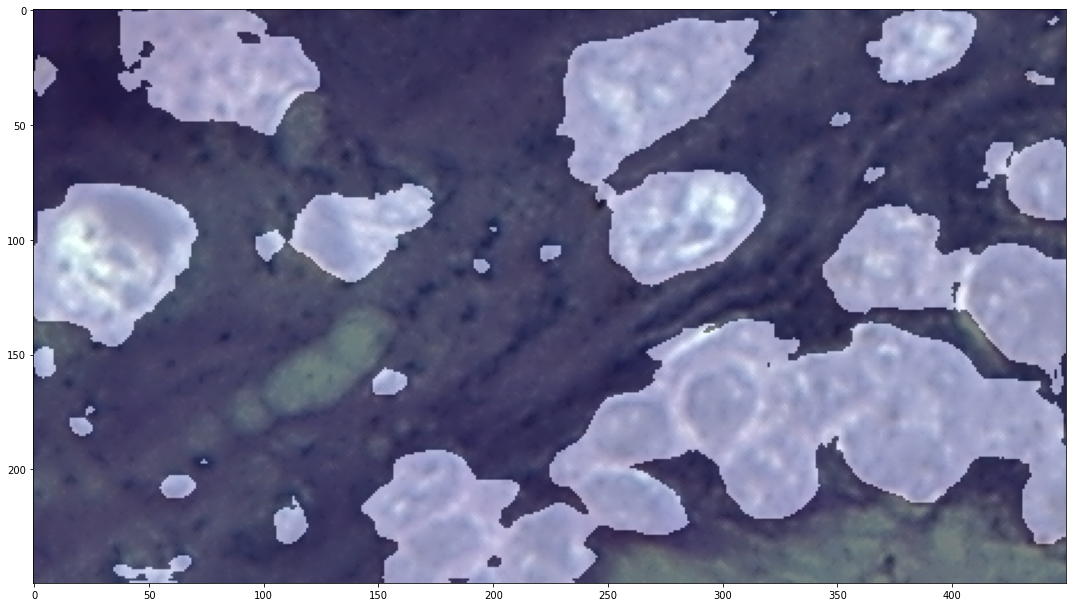

In [17]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

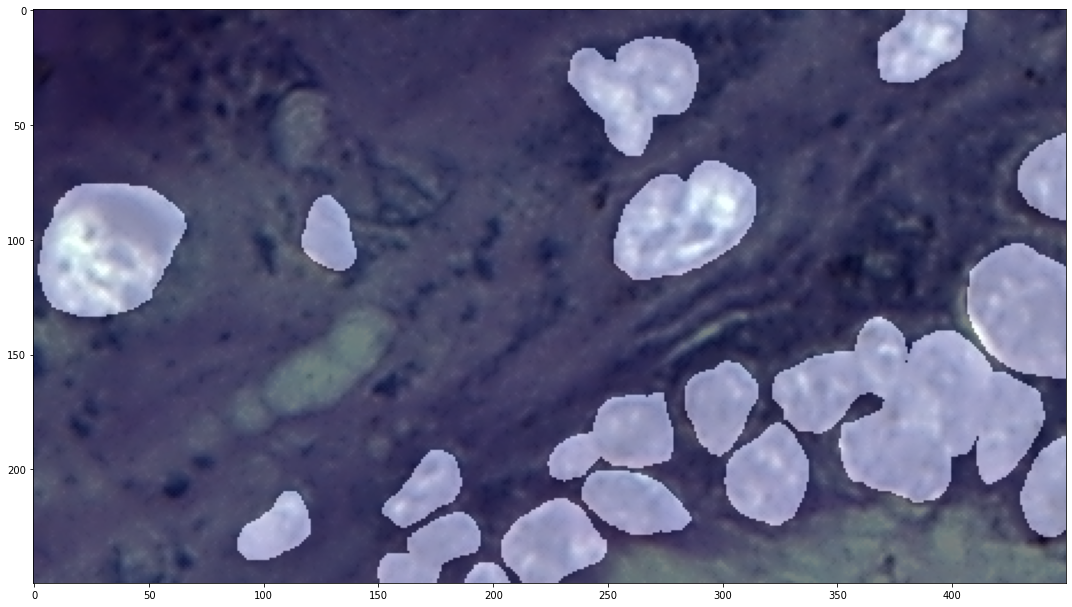

In [18]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')
result = mmcv.imread('ToTrain/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

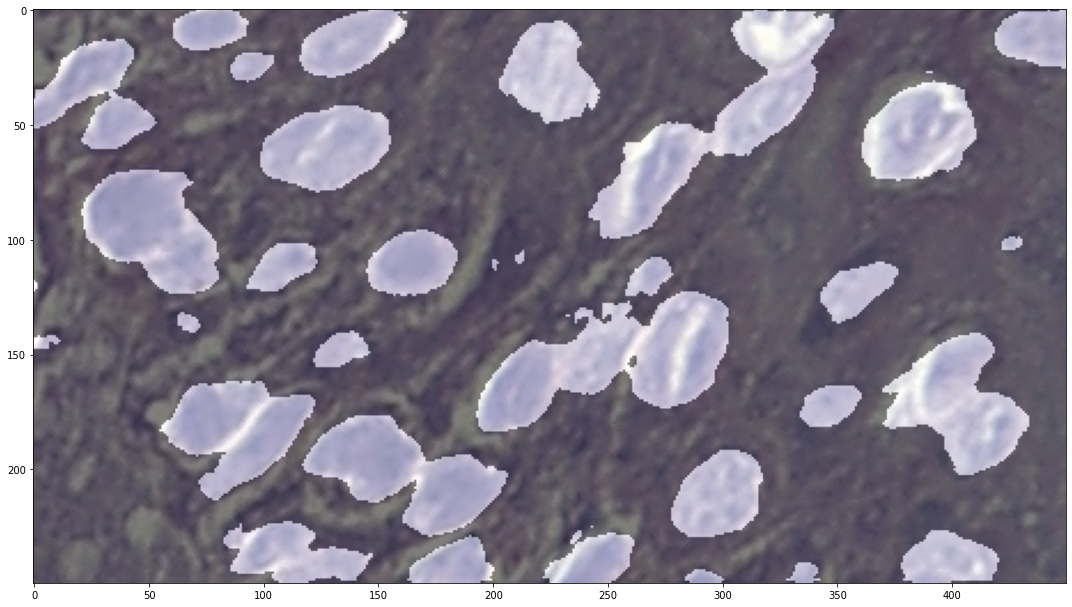

In [19]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

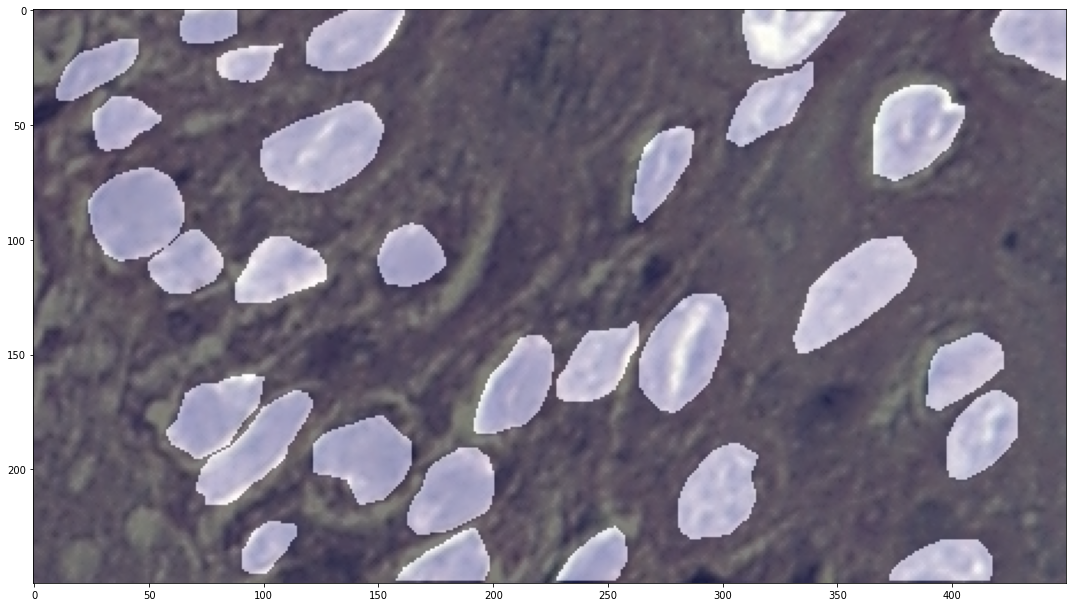

In [20]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')
result = mmcv.imread('ToTrain/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [21]:
!rm -rf segmentation
!unzip /content/drive/MyDrive/TCC/segmentation.zip

Archive:  /content/drive/MyDrive/TCC/segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
   creating: segmentation/annotations/healthy/
  inflating: segmentation/annotations/healthy/image003-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi3.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi4.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi5.tif  
  inflating: segmentation/annotations/healthy/image004-roi1.tif  
  inflating: segmentation/annotations/healthy/image004-roi2.tif  
  inflating: segmentation/annotations/healthy/image004-roi3.tif  
  inflating: segmentation/annotations/healthy/image004-roi4.tif  
  inflating: segmentation/annotations/healthy/image004-roi5.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi1.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi3.tif  
  inflating: segmentation/a

In [22]:
from glob import glob
classes = ['healthy', 'mild', 'moderate', 'severe']
train_images = []
for dysplasia in classes:
    images_glob = glob(f'segmentation/images/{dysplasia}/*')
    for img_path in images_glob:
        img = mmcv.imread(img_path)
        train_images.append((img, f'./work_dirs/psp_resnest_50/raw_res/' + img_path[20:]))

In [23]:
%rm -rf ./work_dirs/psp_resnest_50/raw_res/

In [24]:
%mkdir ./work_dirs/psp_resnest_50/raw_res/
%mkdir ./work_dirs/psp_resnest_50/raw_res/healthy
%mkdir ./work_dirs/psp_resnest_50/raw_res/mild
%mkdir ./work_dirs/psp_resnest_50/raw_res/moderate
%mkdir ./work_dirs/psp_resnest_50/raw_res/severe

In [25]:
import cv2 as cv
opacity = 0.5
fig_size=(15, 10)
for img, path in train_images:
  model.cfg = cfg
  result = inference_segmentor(model, img)
  predict_img = result[0]
  predict_img[predict_img == 1] = 255
  predict_img[predict_img == 0] = 0
  cv.imwrite(f'{path}', predict_img)

In [26]:
%matplotlib inline
import json

file = open('./work_dirs/psp_resnest_50/None.log.json')
lines = file.readlines()

m_dice = []
m_acc = []
loss = []

for line in lines:
    json_line = json.loads(line)
    if len(json_line):
        if json_line['mode'] == 'train':
            loss.append(json_line['loss'])
        else:
            m_acc.append(json_line['mAcc'])
            m_dice.append(json_line['mDice'])

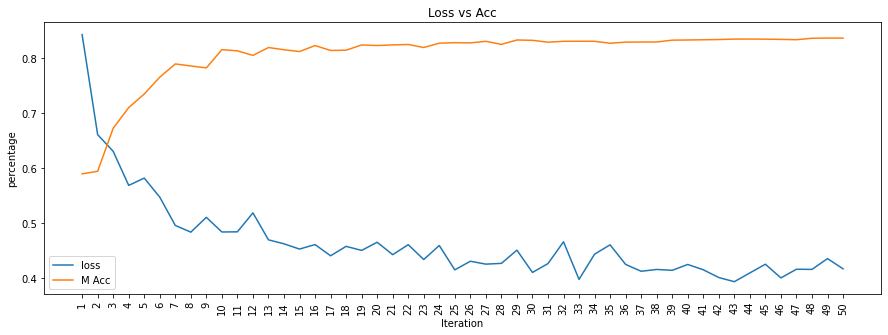

In [27]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), loss, label="loss")
plt.plot(range(1, len(m_acc) + 1), m_acc, label="M Acc")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("Loss vs Acc")
plt.xlabel("Iteration")
plt.ylabel("percentage")
plt.legend()
plt.savefig('./work_dirs/psp_resnest_50/Loss_vs_Acc_Graph.png')
plt.show()

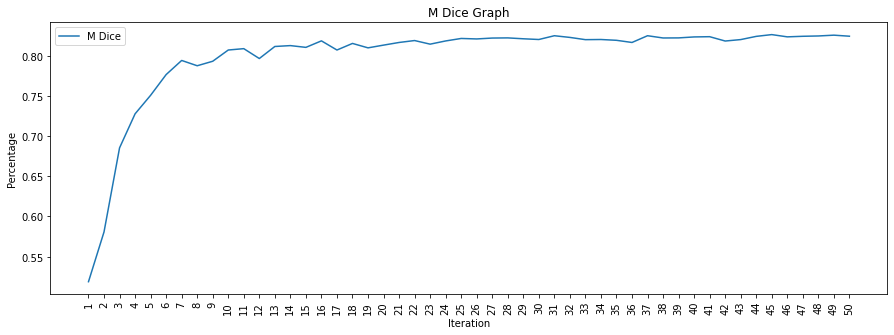

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), m_dice, label="M Dice")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("M Dice Graph")
plt.xlabel("Iteration")
plt.ylabel("Percentage")
plt.legend()
plt.savefig('./work_dirs/psp_resnest_50/M_Dice_Graph.png')
plt.show()
plt.close()

In [29]:
!zip -r pspNet_resnest_50.zip ./work_dirs/psp_resnest_50/

  adding: work_dirs/psp_unet_50/ (stored 0%)
  adding: work_dirs/psp_unet_50/epoch_30.pth (deflated 7%)
  adding: work_dirs/psp_unet_50/epoch_20.pth (deflated 7%)
  adding: work_dirs/psp_unet_50/epoch_50.pth (deflated 7%)
  adding: work_dirs/psp_unet_50/Loss_vs_Acc_Graph.png (deflated 9%)
  adding: work_dirs/psp_unet_50/epoch_40.pth (deflated 7%)
  adding: work_dirs/psp_unet_50/raw_res/ (stored 0%)
  adding: work_dirs/psp_unet_50/raw_res/severe/ (stored 0%)
  adding: work_dirs/psp_unet_50/raw_res/severe/image062-roi1.tif (deflated 2%)
  adding: work_dirs/psp_unet_50/raw_res/severe/image024-roi4.tif (deflated 2%)
  adding: work_dirs/psp_unet_50/raw_res/severe/image061-roi2.tif (deflated 2%)
  adding: work_dirs/psp_unet_50/raw_res/severe/image043-roi1.tif (deflated 4%)
  adding: work_dirs/psp_unet_50/raw_res/severe/image058-roi8.tif (deflated 4%)
  adding: work_dirs/psp_unet_50/raw_res/severe/image058-roi5.tif (deflated 3%)
  adding: work_dirs/psp_unet_50/raw_res/severe/image050-roi1.tif

In [31]:
!cp pspNet_resnest_50.zip /content/drive/MyDrive/TCC/